In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime

In [10]:
from bokeh.io import show, output_notebook, curdoc, push_notebook
output_notebook()
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.models import Arrow, VeeHead
from bokeh.plotting import figure
from bokeh.layouts import row, layout, widgetbox, column
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.widgets import Slider, Select, DateRangeSlider

Loading BokehJS ...

In [11]:
def to_WM(lat, lon):
    '''convert "normal" WGS84 coordinates to the web mercator coordinates that bokeh uses
    code copied from 
    https://gis.stackexchange.com/questions/247871/convert-gps-coordinates-to-web-mercator-epsg3857-using-python-pyproj
    '''
    # derived from the Java version explained here: http://wiki.openstreetmap.org/wiki/Mercator
    RADIUS = 6378137.0 # in meters on the equator

    lat2 = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * RADIUS
    lon2 = np.radians(lon) * RADIUS
    return lat2, lon2

def load_data():
    data_dir = '../boat/data/'
    logs = os.listdir(data_dir)
    dfs= [pd.read_csv(data_dir + fname, sep='\t') for fname in logs]
    merged = pd.concat(dfs)
    
#     convert coords to web mercator projection, which is used by bokeh for plotting
    lat, lon = to_WM(merged['boat_lat'], merged['boat_lon'])
    merged['boat_lat_WM'] = lat
    merged['boat_lon_WM'] = lon
    
#     convert datetime strings into actual datetime objects, then split into two different columns
    merged['datetime'] = merged['datetime'].apply(pd.datetime.strptime, args=("%Y-%m-%d %H:%M:%S",))
    merged['date'] = merged['datetime'].apply(pd.datetime.date)
    merged['time'] = merged['datetime'].apply(pd.datetime.time)
    merged = merged.sort_values(by='datetime')
    merged = merged.set_index('datetime')
    return merged

merged = load_data()
merged.head()

,boat_COG,boat_heading,boat_lat,boat_lon,skiff_COG,skiff_heading,skiff_lat,skiff_lon,boat_lat_WM,boat_lon_WM,date,time
datetime,,,,,,,,,,,,
2018-07-24 16:10:09,NaN,233.128609,61.077967,-146.568223,NaN,NaN,NaN,NaN,8.643748e+06,-1.631590e+07,2018-07-24,16:10:09
2018-07-24 16:10:14,NaN,231.948268,61.077972,-146.568230,NaN,NaN,NaN,NaN,8.643749e+06,-1.631590e+07,2018-07-24,16:10:14
2018-07-24 16:10:14,NaN,232.160508,61.077972,-146.568230,NaN,NaN,NaN,NaN,8.643749e+06,-1.631590e+07,2018-07-24,16:10:14
2018-07-24 16:10:14,NaN,231.768254,61.077972,-146.568230,NaN,NaN,NaN,NaN,8.643749e+06,-1.631590e+07,2018-07-24,16:10:14
2018-07-24 16:10:29,157.56,232.567460,61.077980,-146.568215,NaN,NaN,NaN,NaN,8.643751e+06,-1.631590e+07,2018-07-24,16:10:29


In [12]:
def default_map():
#     the bounds of Prince William Sound in WGS coords
    lo_lat, hi_lat, lo_lon, hi_lon = 60, 61.5, -149, -145.5
#     convert to web mercator
    lo_lat, lo_lon = to_WM(lo_lat, lo_lon)
    hi_lat, hi_lon = to_WM(hi_lat, hi_lon)
    p = figure(x_range=(lo_lon, hi_lon), 
           y_range=(lo_lat, hi_lat), 
           x_axis_type="mercator", 
           y_axis_type="mercator",
           tools="pan,wheel_zoom,reset,zoom_in,zoom_out",
           active_scroll='wheel_zoom')
    p.add_tile(CARTODBPOSITRON)
    
    my_hover = HoverTool()
    my_hover.tooltips = [('Time:', '@datetime')]
    p.add_tools(my_hover)
    return p

def draw_boat_COG_arrows(fig, df, color='blue', interval=12):
    i = interval
    for line in df.iterrows():
        i += 1
        if i >= interval:
            hdg = line[1]['boat_COG']
            if np.isfinite(hdg):
                i = 0
                hdg = ((90-hdg) % 360) * (np.pi/180) #convert to traditional math angle
                x,y = line[1]['boat_lon_WM'], line[1]['boat_lat_WM']
                SIGMA = .0000001
                dx = SIGMA*np.cos(hdg)
                dy = SIGMA*np.sin(hdg)
                fig.add_layout(Arrow(end=VeeHead(size=7, 
                                                 fill_color=color,
                                                 line_color=color), 
                                     line_color=color,
                                     x_start=x, 
                                     y_start=y, 
                                     x_end=x+dx, 
                                     y_end=y+dy))

def draw_boat_track(fig, df, color='blue'):
    fig.line(x='boat_lon_WM', y='boat_lat_WM', source=df, color=color)


In [16]:
source = ColumnDataSource(data=merged)
callback = CustomJS(args=dict(source=source), code="""
    console.log("slider changed!")
    //var data = source.data;
    //var f = cb_obj.value
    //var x = data['x']
    //var y = data['y']
    //for (var i = 0; i < x.length; i++) {
    //    y[i] = Math.pow(x[i], f)
    //}
    //source.change.emit();
""")

slider = DateRangeSlider(start=merged['date'].min(),
                         end  =merged['date'].max(), 
                         value=(merged['date'].min(),merged['date'].max()),
                         step =1, 
                         title="dates")
slider.js_on_change('value', callback)

def reload_and_show():
    data = load_data()
    m = default_map()
    draw_boat_track(m, data)
    draw_boat_COG_arrows(m, data)
    layout = column(slider, m)

    show(layout)

In [17]:
reload_and_show()

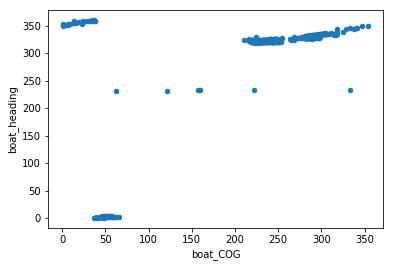

In [8]:
merged.plot.scatter(x='boat_COG', y='boat_heading')